<a href="https://colab.research.google.com/github/jubeam/my_js_project/blob/master/image_%EC%A7%80%EB%8F%84%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install lime

     |████████████████████████████████| 276kB 4.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/e0/1f/99/f7e0dfa6a933ecc28d565cb03f7f02b594e2c6751ba8f042d2
Successfully built lime


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 30001     
Total params: 30,001
Trainable params: 30,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
10/10 [==============================] - 3s 295ms/step - loss: 2.3539 - acc: 0.5000 - val_loss: 0.2400 - val_acc: 0.9938
Epoch 2/5
10/10 [==============================] - 2s 186ms/step - loss: 1.1806 - acc: 0.5281 - val_loss: 1.7201 - val_acc: 0.0625
Epoch 3/5
10/10 [==============================] - 2s 200ms/step - loss: 0.9639 - acc: 0.5000 - val_loss: 1.1115 - val_acc: 0.5000
Epoch 4/5
10/10 [==============================] - 2s 203m

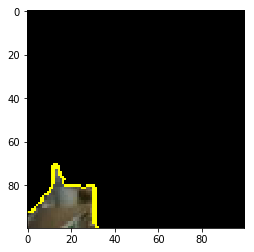

In [0]:
from PIL import Image
from PIL import ImageFilter
import numpy
from PIL import ImageDraw, ImageFont
import os


image_path='jubeam.jpg'

image=Image.open(image_path)

image
image.resize((128, 128))  # 픽셀 단위
resize = image.resize((128, 128))
resize.save('resized.jpg')
resize.rotate(45)  # 반시계방향 각도
resize.transpose(Image.FLIP_TOP_BOTTOM)
resize.transpose(Image.FLIP_LEFT_RIGHT)
resize.transpose(Image.ROTATE_90)
resize.filter(ImageFilter.BLUR)
resize.filter(ImageFilter.EMBOSS)
resize.filter(ImageFilter.CONTOUR)
resize.filter(ImageFilter.DETAIL)
resize.filter(ImageFilter.EDGE_ENHANCE)
resize.filter(ImageFilter.SMOOTH)
resize.convert('L')  # ITU-R 601-2 luma transform
m = numpy.asarray(resize)
m.shape
bw = numpy.asarray(resize.convert('L'))
bw.shape


#실습에서 쓸 데이터는 캐글에서 강아지와 고양이를 구분하는 경연용 데이터(www.kaggle.com/c/dogs-vs-cats/data)
from urllib.request import urlretrieve
urlretrieve('http://doc.mindscale.kr/km/unstructured/dog-vs-cat.zip',
            'dog-vs-cat.zip')
from zipfile import ZipFile

with ZipFile('dog-vs-cat.zip') as z:
    z.extractall()
    
from keras.preprocessing.image import load_img 
img = load_img('dog-vs-cat/train/cat/cat.1.jpg')
img


#학습용 데이터의 중강(Data Augumentation)
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(
        rescale=1/255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )

train = img_gen.flow_from_directory(
    'dog-vs-cat/train',     # 이미지 디렉토리
    target_size=(100, 100), # 변환할 크기는 가로 100, 세로 100
    color_mode='rgb',       # 컬러는 rgb, 흑백은 grayscale. 생략하면 컬러로 처리한다
    class_mode='binary')    # 고양이 vs. 개로 binary 분류

#검증용 데이터도 불러오자. 방법은 동일하다. 검증용 데이터는 증강시킬 필요가 없다.
valid = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    'dog-vs-cat/validation',
    target_size=(100, 100),
    class_mode='binary',
    shuffle=False)

#로지스틱 회귀분석 모형
from keras import Sequential
from keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=(100, 100, 3)))
model.add(Dense(1, activation='sigmoid'))
model.summary()
#크로스엔트로피는 직관적으로 이해하기 어려운 지표이다. 우리가 성능을 확인하기 위해 추가로 정확도(accuracy)를 계산한다. 정확도는 전체 데이터에서 올바르게 분류한 사례의 비율을 나타낸다.

#마지막으로 최적화 알고리즘은 실제 학습 방법을 결정한다. RMSprop이나 Adam을 사용한다.

from keras.optimizers import Adam
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.001))

#학습 5회
vaild=5
model.fit_generator(train, validation_data=valid,steps_per_epoch=10, validation_steps=5, epochs=5)

img = load_img('dog-vs-cat/validation/cat/cat.1000.jpg', target_size=(100, 100))
img

import numpy
img_array = numpy.array(img) / 255
img_array.shape
model.predict(numpy.array([img_array]))

from lime.lime_image import LimeImageExplainer

explainer = LimeImageExplainer()
explanation = explainer.explain_instance(img_array, model.predict, num_samples=30)
temp, mask = explanation.get_image_and_mask(label=0, hide_rest=True)
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(mark_boundaries(temp, mask))


from keras.callbacks import TensorBoard
LOG_DIR = 'log_model'
model.fit_generator(
    train, validation_data=valid, steps_per_epoch=10, validation_steps=5,epochs=5,
    callbacks=[
        TensorBoard(log_dir=LOG_DIR)
    ])

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip
get_ipython().system_raw(f'tensorboard --logdir {LOG_DIR} --host 0.0.0.0 --port 6006 &')
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | tr '"' '\n' | grep "https://"

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2019-07-03 03:44:48--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.207.111.186, 52.3.53.115, 52.203.102.189, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.207.111.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17556757 (17M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  16.74M  20.3MB/s    in 0.8s    

2019-07-03 03:44:50 (20.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [17556757/17556757]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
get_ipython().system_raw(f'tensorboard --logdir {LOG_DIR} --host 0.0.0.0 --port 6006 &')
get_ipython().system_raw('./ngrok http 6006 &')
curl -s http://localhost:4040/api/tunnels | tr '"' '\n' | grep "https://"

SyntaxError: ignored

In [0]:
tensorboard --host=127.0.0.1 --logdir=log_model

SyntaxError: ignored

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving jubeam.jpg to jubeam.jpg
User uploaded file "jubeam.jpg" with length 8043 bytes


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))